In [70]:
%matplotlib inline
import numpy as np
import nltk
import glob
import os
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.cluster import KMeans
import pandas as pd
from sklearn.mixture import GMM
from sklearn.metrics import silhouette_score
import matplotlib.pyplot as plt
import sklearn.decomposition
from collections import defaultdict
import csv
import string
from scipy.cluster.hierarchy import dendrogram, linkage, fcluster, fclusterdata
from sklearn import manifold
from sklearn.metrics import euclidean_distances
from sklearn.feature_extraction import DictVectorizer
from nltk.util import ngrams

In [2]:
#Load Shakespeare scenes
f = open('shakespeare_scenes.txt')
shk = f.read()
shakespeare_scenes = eval(shk)
f.close()

#Load Shakespeare acts
f = open('shakespeare_acts.txt')
shk = f.read()
shakespeare_acts = eval(shk)
f.close()

In [91]:
#Create baseline of all text in all plays
all_acts_text = []
all_acts_lines = []
for act in shakespeare_acts:
    all_acts_text.append(act['text'])
all_text = ' '.join(all_acts_text).lower()
all_lines = ' '.join(all_acts_lines)
all_tokens = nltk.word_tokenize(all_text)
all_freq = nltk.FreqDist(all_tokens)
#Get top 75 most frequent terms across all plays - remove punctuation we are using for structure vector
vocabulary = [item[0] for item in sorted(all_freq.items(), key=lambda x: x[1], reverse=True) if item[0] not in[";", ",", ":", ".", "?", "!", "'"]][:75]
print (vocabulary)

['the', 'and', 'i', 'to', 'of', 'you', 'a', 'my', 'that', 'in', 'is', 'not', 'me', 'it', 'for', "'s", 'with', 'be', 'your', 'he', 'this', 'his', 'but', 'have', 'as', 'thou', "'d", 'him', 'so', 'will', 'what', 'thy', 'her', 'do', 'no', 'all', 'by', 'we', 'shall', 'if', 'are', 'thee', 'our', 'on', 'good', 'now', 'lord', 'o', 'from', 'come', 'sir', "'ll", 'she', 'at', 'they', 'or', 'was', 'let', 'which', 'here', 'more', 'would', 'there', 'well', 'how', 'then', 'am', '--', 'love', 'when', 'their', 'can', 'man', 'them', 'hath']


In [50]:
#Set up iambic pentameter measure
stress_dict = {}
with open('stress.txt', 'r') as f:
    for line in f:
        word_stress = line.strip().split(',')
        word = word_stress[0].strip().lower()
        stress = word_stress[1].strip()
        stress_dict[word] = stress
print(len(stress_dict))
f.close()

def is_in_dict(word):
    if word in stress_dict:
        return stress_dict[word]
    else :
        return '3333333333'
    
def is_iambic_pentameter(line):
    line_stresses= [is_in_dict(word) for word in line.split()] 
    line_stresses=''.join(line_stresses)
    #return line_stresses
    return len(line_stresses) == 10

#pure iambic pentameter is '0101010101'
#print(len('0101010101'))

23118


In [149]:
#Define features for structural feature vector

def structural(data):
    elements_text = [element['text'] for element in data]
    elements_lines = [element['lines'] for element in data]
    elements_count = len(data)
    
    features = np.zeros((elements_count, 16), np.float64)
    for i, element in enumerate(elements_lines):
        text = ' '.join(element)
        lines = element
        lines_count = len(lines)
        tokens = nltk.word_tokenize(text.lower())
        sentences = nltk.data.load('tokenizers/punkt/english.pickle').tokenize(text.lower())
        sentences_count = len(sentences)
        words = nltk.tokenize.RegexpTokenizer(r'\w+').tokenize(text.lower())
        words_unique = list(set(words))        
        words_line_counts = [len(nltk.tokenize.RegexpTokenizer(r'\w+').tokenize(line.lower())) for line in lines]
        words_sent_counts = [len(nltk.tokenize.RegexpTokenizer(r'\w+').tokenize(sentence.lower())) for sentence in sentences]
        if len(words_line_counts) == 0 or len(words_sent_counts) == 0:
            print (words_line_counts, words_sent_counts, i, element)
        
        #Calculate features
        mean_word_freq = float(len(words))/float(len(words_unique))
        mean_words_line = np.mean(words_line_counts)
        std_words_line = np.std(words_line_counts)
        mean_words_sent = np.mean(words_sent_counts)
        std_words_sent = np.std(words_sent_counts)
        mean_commas_line = float(tokens.count(","))/float(lines_count)
        mean_commas_sent = float(tokens.count(","))/float(sentences_count)
        mean_colons_line = float(tokens.count(":"))/float(lines_count)
        mean_colons_sent = float(tokens.count(":"))/float(sentences_count)
        mean_scolons_line = float(tokens.count(";"))/float(lines_count)
        mean_scolons_sent = float(tokens.count(";"))/float(sentences_count)
        mean_qmarks_line = float(tokens.count("?"))/float(lines_count)
        mean_qmarks_sent = float(tokens.count("?"))/float(sentences_count)
        mean_exmarks_line = float(tokens.count("!"))/float(lines_count)
        mean_exmarks_sent = float(tokens.count("!"))/float(sentences_count)
        
        #Calculate iambic pentameter measures
        iambic=0
        noniambic=0
        for line in lines:
            line = line.rstrip()
            line = line.lower()
            exclude = set(string.punctuation)
            line = ''.join(ch for ch in line if ch not in exclude)
            if is_iambic_pentameter(line):
                iambic=iambic+1
            else:
                noniambic=noniambic+1
        ia = float(iambic)/float(iambic+noniambic)
        
        #Assign features to matrix
        features[i,0] = mean_word_freq
        features[i,1] = mean_words_line
        features[i,2] = std_words_line
        features[i,3] = mean_words_sent
        features[i,4] = std_words_sent
        features[i,5] = mean_commas_line
        features[i,6] = mean_commas_sent
        features[i,7] = mean_colons_line
        features[i,8] = mean_colons_sent
        features[i,9] = mean_scolons_line
        features[i,10] = mean_scolons_sent
        features[i,11] = mean_qmarks_line
        features[i,12] = mean_qmarks_sent
        features[i,13] = mean_exmarks_line
        features[i,14] = mean_exmarks_sent 
        features[i,15] = ia
        
        #normalize
        struc_vec = (features - features.mean(axis=0))/features.std(axis=0)

    return struc_vec

In [133]:
#Define word frequency vector for most common terms

def word_freq(data):
    elements_text = [element['text'].lower() for element in data]
    
    vectorizer = CountVectorizer(vocabulary=vocabulary, tokenizer=nltk.word_tokenize)
    freq_vec = vectorizer.fit_transform(elements_text).toarray().astype(np.float64)
    
    #Normalize
    freq_vec = (freq_vec - freq_vec.mean(axis=0))/freq_vec.std(axis=0)
 
    return freq_vec

In [76]:

def ngram_freq(text, n):
    tokens = [item for item in nltk.word_tokenize(text) if item not in string.punctuation]#[',', '.']]
    ng = ngrams(tokens, n)
    ng_freq = nltk.FreqDist(ng)
    return ng_freq


In [122]:
ng_all = ngram_freq(all_text,4)
ng_all_freq = [item[0] for item in sorted(ng_all.items(), key=lambda x: x[1], reverse=True)][:100]
#ng_all_freq = [' '.join(item[0]) for item in sorted(ng_all.items(), key=lambda x: x[1], reverse=True)][:50]
print(ng_all_freq)

[('what', "'s", 'the', 'matter'), ('with', 'all', 'my', 'heart'), ('i', 'know', 'not', 'what'), ('i', 'do', 'beseech', 'you'), ('i', "'ll", 'tell', 'you'), ('it', 'can', 'not', 'be'), ('give', 'me', 'your', 'hand'), ('i', 'can', 'not', 'tell'), ('give', 'me', 'thy', 'hand'), ('i', 'do', 'not', 'know'), ('my', 'lord', 'my', 'lord'), ('i', 'would', 'not', 'have'), ('i', "'ll", 'be', 'sworn'), ('for', 'god', "'s", 'sake'), ('what', 'is', 'the', 'matter'), ('i', "'ll", 'tell', 'thee'), ('ay', 'my', 'good', 'lord'), ('give', 'me', 'leave', 'to'), ('i', 'can', 'tell', 'you'), ('i', 'pray', 'you', 'sir'), ('as', 'i', 'am', 'a'), ('for', 'mine', 'own', 'part'), ('what', "'s", 'the', 'news'), ('i', 'take', 'my', 'leave'), ('by', 'my', 'troth', 'i'), ('a', 'word', 'with', 'you'), ('no', 'my', 'good', 'lord'), ('it', 'shall', 'be', 'so'), ("'t", 'is', 'not', 'so'), ('i', 'am', 'a', 'gentleman'), ('i', "'ll", 'to', 'the'), ('can', 'not', 'choose', 'but'), ('the', 'duke', 'of', 'york'), ('i', 'know

In [123]:
#Define ngram tokenizer
def ng_tokenizer(text):
    return [' '.join(item) for item in ngram_freq(text, 4)]

#Build ngram vector
def ngram_freq_vec(data):
    elements_text = [element['text'].lower() for element in data]
    elements_count = len(elements_text)
    
    #elements_ngram = [[' '.join(item) for item in ngram_freq(element, 3)] for element in elements_text]
    ng_all_freq_combined = [' '.join(i) for i in ng_all_freq]
    
    ng_freq_vec = np.zeros((elements_count, 100), np.float64)
            
    ng_all_freq_combined = [' '.join(i) for i in ng_all_freq]
    vectorizer = CountVectorizer(vocabulary=ng_all_freq_combined, tokenizer=ng_tokenizer)#, tokenizer=nltk.word_tokenize)
    ng_freq_vec = vectorizer.fit_transform(elements_text).toarray().astype(np.float64)
    ng_freq_vec = (ng_freq_vec - ng_freq_vec.mean(axis=0))/ng_freq_vec.std(axis=0)
    return ng_freq_vec

In [152]:
#Output vectors to files for futher processing

freqa = pd.DataFrame(word_freq(shakespeare_acts))
freqs = pd.DataFrame(word_freq(shakespeare_scenes))
nga = pd.DataFrame(ngram_freq_vec(shakespeare_acts))
ngs = pd.DataFrame(ngram_freq_vec(shakespeare_scenes))
struca = pd.DataFrame(structural(shakespeare_acts))
strucs = pd.DataFrame(structural(shakespeare_scenes))
freqa['Title'] = [item['title'] for item in shakespeare_acts]
struca['Title'] = [item['title'] for item in shakespeare_acts]
nga['Title'] = [item['title'] for item in shakespeare_acts]
freqs['Title'] = [item['title'] for item in shakespeare_scenes]
strucs['Title'] = [item['title'] for item in shakespeare_scenes]
ngs['Title'] = [item['title'] for item in shakespeare_scenes]
freqa['Act'] = [item['act'] for item in shakespeare_acts]
nga['Act'] = [item['act'] for item in shakespeare_acts]
ngs['Act'] = [item['act'] for item in shakespeare_scenes]
freqs['Act'] = [item['act'] for item in shakespeare_scenes]
struca['Act'] = [item['act'] for item in shakespeare_acts]
strucs['Act'] = [item['act'] for item in shakespeare_scenes]
freqs['Scene'] = [item['scene'] for item in shakespeare_scenes]
strucs['Scene'] = [item['scene'] for item in shakespeare_scenes]
ngs['Scene'] = [item['scene'] for item in shakespeare_scenes]
freqa.to_csv('freq_acts.csv')
freqs.to_csv('freq_scenes.csv')
struca.to_csv('struc_acts.csv')
strucs.to_csv('struc_scenes.csv')
nga.to_csv('ng_acts.csv')
ngs.to_csv('ng_scenes.csv')

In [153]:
#Cluster using different methods for authorship

def authorship(data, clusters):
    freq = word_freq(data)
    freq_ng = ngram_freq_vec(data)
    struc = structural(data)
    
    #K-Means Clustering
    km_freq = KMeans(n_clusters=clusters, init='k-means++', n_init=99)
    km_freq_ng = KMeans(n_clusters=clusters, init='k-means++', n_init=99)
    km_struc = KMeans(n_clusters=clusters, init='k-means++', n_init=99)
    km_freq.fit(freq)
    km_freq_ng.fit(freq_ng)
    km_struc.fit(struc)
    km_freq_pred = km_freq.predict(freq)
    km_freq_ng_pred = km_freq_ng.predict(freq_ng)
    km_struc_pred = km_struc.predict(struc)
    km_freq_score = silhouette_score(freq, km_freq_pred, metric='sqeuclidean')
    km_freq_ng_score = silhouette_score(freq_ng, km_freq_ng_pred, metric='sqeuclidean')
    km_struc_score = silhouette_score(struc, km_struc_pred, metric='sqeuclidean')
    
    #Gaussian MixtureModel Clustering
    gmm_freq = GMM(n_components = clusters, covariance_type="full")
    gmm_freq_ng = GMM(n_components = clusters, covariance_type="full")
    gmm_struc = GMM(n_components = clusters, covariance_type="full")
    gmm_freq.fit(freq)
    gmm_freq_ng.fit(freq_ng)
    gmm_struc.fit(struc)
    gmm_freq_pred = gmm_freq.predict(freq)
    gmm_freq_ng_pred = gmm_freq_ng.predict(freq_ng)
    gmm_struc_pred = gmm_struc.predict(struc)
    gmm_freq_score = silhouette_score(freq, gmm_freq_pred, metric='sqeuclidean')
    gmm_freq_ng_score = silhouette_score(freq_ng, gmm_freq_ng_pred, metric='sqeuclidean')
    gmm_struc_score = silhouette_score(struc, gmm_struc_pred, metric='sqeuclidean')
    
    #Hierarchical clustering
    hiey_freq = linkage(freq,'ward')
    hiey_freq_ng = linkage(freq, 'ward')
    hiey_struc = linkage(struc,'ward')
    freq_clusters = fcluster(hiey_freq,clusters,criterion='maxclust')
    freq_ng_clusters = fcluster(hiey_freq_ng,clusters,criterion='maxclust')
    struc_clusters = fcluster(hiey_struc,clusters,criterion='maxclust')
    hiey_freq_score = silhouette_score(freq,freq_clusters,metric='euclidean')
    hiey_freq_ng_score = silhouette_score(freq_ng,freq_ng_clusters,metric='euclidean')
    hiey_struc_score = silhouette_score(struc,struc_clusters,metric='euclidean')
    
    return [km_freq, km_freq_score], [km_freq_ng, km_freq_ng_score], [km_struc, km_struc_score], [gmm_freq, gmm_freq_score], [gmm_freq_ng, gmm_freq_ng_score], [gmm_struc, gmm_struc_score], [hiey_freq, hiey_freq_score], [hiey_freq_ng, hiey_freq_ng_score], [hiey_struc, hiey_struc_score]

In [154]:
km_acts_freq, km_acts_freq_ng, km_acts_struc, gmm_acts_freq, gmm_acts_freq_ng, gmm_acts_struc, hiey_acts_freq, hiey_acts_freq_ng, hiey_acts_struc = authorship(shakespeare_acts, 3)
km_scenes_freq, km_scenes_freq_ng, km_scenes_struc, gmm_scenes_freq, gmm_scenes_freq_ng, gmm_scenes_struc, hiey_scenes_freq, hiey_scenes_freq_ng, hiey_scenes_struc = authorship(shakespeare_scenes, 3)

print ("Acts Scores:")
print("Frequency: gmm:", gmm_acts_freq[1], "km:", km_acts_freq[1], "hierarchy:", hiey_acts_freq[1])
print("Frequency ngram: gmm:", gmm_acts_freq_ng[1], "km:", km_acts_freq_ng[1], "hierarchy:", hiey_acts_freq_ng[1])
print("Structural: gmm:", gmm_acts_struc[1], "km:", km_acts_struc[1], "hierarchy:", hiey_acts_struc[1])
print ("Scenes Scores:")
print("Frequency: gmm:", gmm_scenes_freq[1], "km:", km_scenes_freq[1], "hierarchy:", hiey_scenes_freq[1])
print("Frequency ngram: gmm:", gmm_scenes_freq_ng[1], "km:", km_scenes_freq_ng[1], "hierarchy:", hiey_scenes_freq_ng[1])
print("Structural: gmm:", gmm_scenes_struc[1], "km:", km_scenes_struc[1], "hierarchy:", hiey_scenes_struc[1])


Acts Scores:
Frequency: gmm: 0.368556864607 km: 0.378976149836 hierarchy: 0.233073407029
Frequency ngram: gmm: 0.141181595906 km: 0.143897864652 hierarchy: -0.198602941022
Structural: gmm: 0.283360065667 km: 0.278766948248 hierarchy: 0.136797726151
Scenes Scores:
Frequency: gmm: 0.422254647261 km: 0.520107527189 hierarchy: 0.393071272959
Frequency ngram: gmm: 0.469886963131 km: 0.633487271262 hierarchy: 0.287864698887
Structural: gmm: 0.32708441848 km: 0.325579453005 hierarchy: 0.331548851501


C:\Users\greeniend\Anaconda\envs\py3k\lib\site-packages\numpy\core\_methods.py:59: RuntimeWarning: Mean of empty slice.
  warnings.warn("Mean of empty slice.", RuntimeWarning)


C:\Users\greeniend\Anaconda\envs\py3k\lib\site-packages\numpy\core\_methods.py:59: RuntimeWarning: Mean of empty slice.
  warnings.warn("Mean of empty slice.", RuntimeWarning)


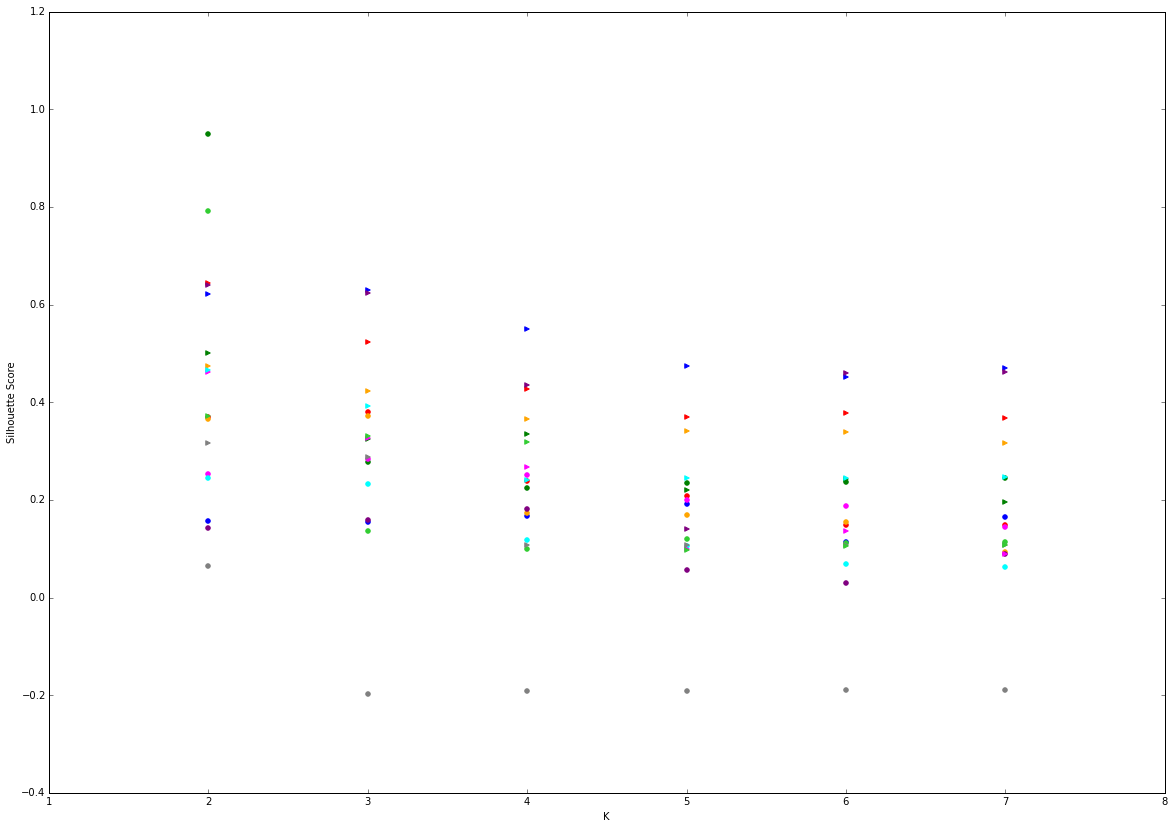

In [155]:
#Graph silhouette scores to choose best value for k

colors = ['red', 'blue', 'green', 'orange', 'purple', 'magenta', 'cyan', 'gray', 'limegreen', 'chocolate']
labels =['km_freq', 'km_freq_ng', 'km_struc','gmm_freq', 'gmm_freq_ng', 'gmm_struc', 'hierarchical_freq', 'hierarchical_freq_ng', 'hierarchical_struc']

plt.figure(figsize=(20,14))

fa = open('sil_scores_acts.csv', 'w')
writer = csv.writer(fa)
writer.writerow(['Clusters','Type', 'Word Freq KM', 'N-Gram Freq KM', 'Structural KM', 'Word Freq GMM', 'N-Gram Freq GMM', 'Structural GMM', 'Word Freq Hierarchical', 'N-Gram Freq Hierarchical', 'Structural Hierarchical'])

for k in range(2,8):
    scores_acts = [item[1] for item in authorship(shakespeare_acts, k)]
    scores_scenes = [item[1] for item in authorship(shakespeare_scenes, k)]
    writer.writerow([k,'acts', scores_acts[0], scores_acts[1], scores_acts[2], scores_acts[3], scores_acts[4], scores_acts[5], scores_acts[6], scores_acts[7], scores_acts[8]])
    writer.writerow([k,'scenes', scores_scenes[0], scores_scenes[1], scores_scenes[2], scores_scenes[3], scores_scenes[4], scores_scenes[5], scores_scenes[6], scores_scenes[7], scores_scenes[8]])
    for i, item in enumerate (scores_acts):
        plt.scatter(k, item, color=colors[i], label=labels[i] + "_acts")
    for i, item in enumerate (scores_scenes):
        plt.scatter(k, item, color=colors[i], marker=">", label=labels[i] + "_scenes")
        
fa.close()

plt.xlabel("K")
plt.ylabel("Silhouette Score")
plt.show()
    
    

In [158]:
columns = ['Title', 'Act', 'Frequency_km', 'Structural_km']
clusters = pd.DataFrame(columns = columns)
clusters['Title'] = [item['title'] for item in shakespeare_acts]
clusters['Act'] = [item['act'] for item in shakespeare_acts]
clusters['Frequency_km'] = km_acts_freq[0].labels_
clusters['Ngram_km'] = km_acts_freq_ng[0].labels_
clusters['Structural_km'] = km_acts_struc[0].labels_
print (clusters)
clusters.to_csv('clusters_acts.csv')

                            Title Act  Frequency_km  Structural_km  Ngram_km
0       All's Well That Ends Well   1             1              1         0
1       All's Well That Ends Well   2             0              1         0
2       All's Well That Ends Well   3             1              1         1
3       All's Well That Ends Well   4             0              0         1
4       All's Well That Ends Well   5             1              1         1
5                  As You Like It   1             0              0         0
6                  As You Like It   2             1              1         0
7                  As You Like It   3             0              0         0
8                  As You Like It   4             1              0         0
9                  As You Like It   5             1              1         1
10           The Comedy of Errors   1             1              1         1
11           The Comedy of Errors   2             1              0         1

In [159]:
columns = ['Title', 'Act', 'Scene', 'Frequency_km', 'Structural_km']
clusters = pd.DataFrame(columns = columns)
clusters['Title'] = [item['title'] for item in shakespeare_scenes]
clusters['Act'] = [item['act'] for item in shakespeare_scenes]
clusters['Scene'] = [item['scene'] for item in shakespeare_scenes]
clusters['Frequency_km'] = km_scenes_freq[0].labels_
clusters['Ngram_km'] = km_scenes_freq_ng[0].labels_
clusters['Structural_km'] = km_scenes_struc[0].labels_
print (clusters)
clusters.to_csv('clusters_scenes.csv')

                         Title Act Scene  Frequency_km  Structural_km  \
0    All's Well That Ends Well   1     1             2              0   
1    All's Well That Ends Well   1     2             0              1   
2    All's Well That Ends Well   1     3             2              0   
3    All's Well That Ends Well   2     1             2              0   
4    All's Well That Ends Well   2     2             0              0   
5    All's Well That Ends Well   2     3             1              0   
6    All's Well That Ends Well   2     4             0              0   
7    All's Well That Ends Well   2     5             0              0   
8    All's Well That Ends Well   3     1             0              1   
9    All's Well That Ends Well   3     2             2              0   
10   All's Well That Ends Well   3     3             0              1   
11   All's Well That Ends Well   3     4             0              1   
12   All's Well That Ends Well   3     5           

In [160]:
struca = structural(shakespeare_acts)
freqa = word_freq(shakespeare_acts)
freqs = word_freq(shakespeare_scenes)
strucs = structural(shakespeare_scenes)
names = [item['title'] + " " + item['act'] for item in shakespeare_acts]
names_s = [item['title'] + " " + item['act'] + " " + item['scene'] for item in shakespeare_scenes]

IndexError: list index out of range

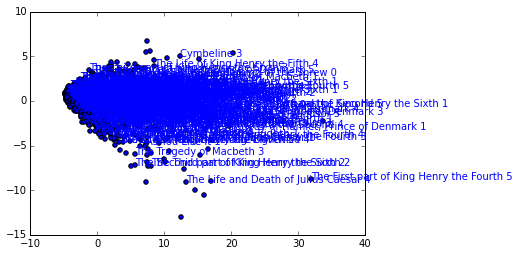

In [69]:
#SAMMON Projection

vec_df = pd.DataFrame(freqs)

mds = manifold.MDS(n_components=2,max_iter=3000,eps=1e-9,dissimilarity="precomputed")
similarities = euclidean_distances(vec_df.ix[:,0:29])
points = mds.fit_transform(similarities)

colDict = {"act1":"red", "act2":"orange", "act3":"green", "act4":"violet", "act5":"blue"}

def textScatter(inX,inY,t,colDict,c=[]):
    ax=plt.axes()
    ax.scatter(inX,inY)
    for i,j in enumerate(zip(inX,inY)):
        if any(c):                      
            ax.text(j[0], j[1], t[i], color="blue")#colDict[c[i]])
        else:                       
            ax.text(j[0], j[1], t[i], color="blue")
    plt.title("Sammon Projection")
    plt.show()

textScatter(points[:, 0] , points[:, 1], names, colDict)

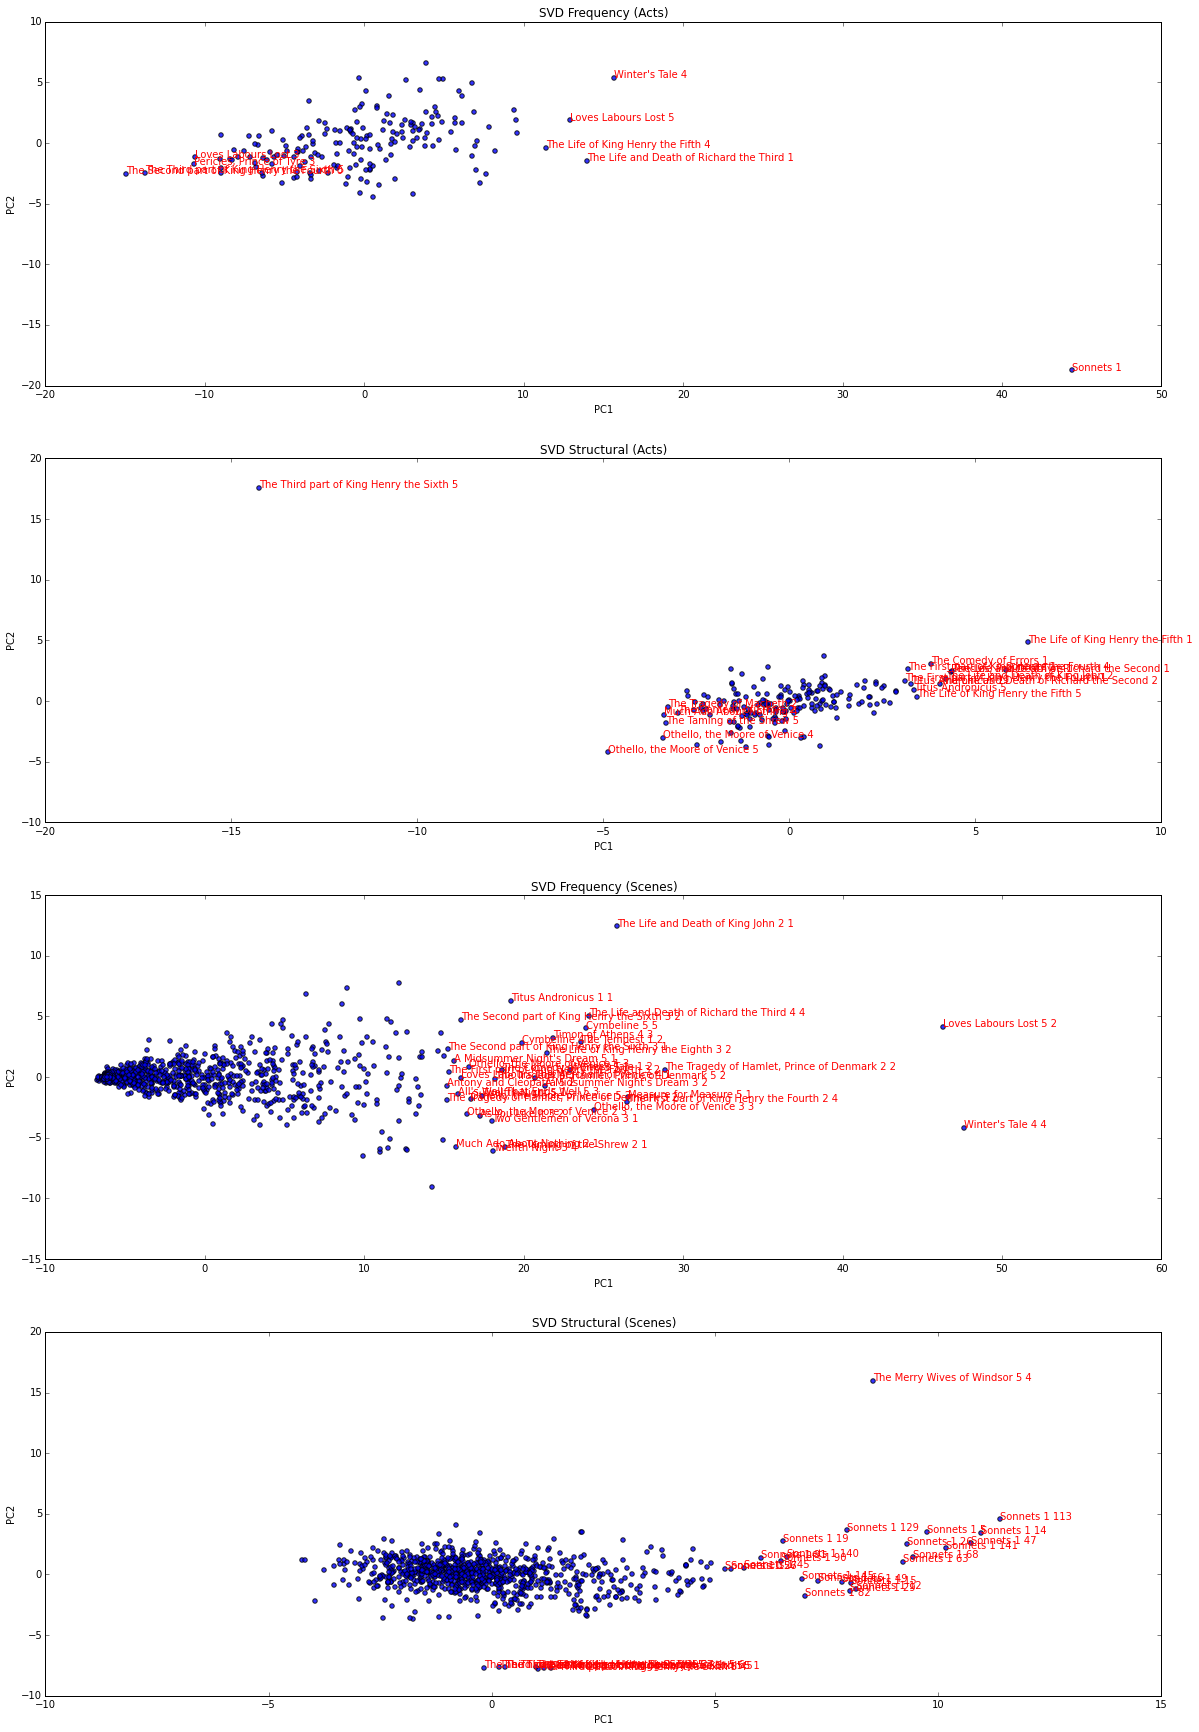

In [162]:
#SVD
svd = sklearn.decomposition.TruncatedSVD(n_components=2)
fig = plt.figure(figsize=(20,30))

freq_2d = svd.fit_transform(freqa)
ax = fig.add_subplot(4, 1, 1)
ax.scatter(freq_2d[:,0], freq_2d[:,1], alpha=0.8)
ax.set_title('SVD Frequency (Acts)')
ax.set_xlabel('PC1')
ax.set_ylabel('PC2')
for x, y, name in zip(freq_2d[:,0],freq_2d[:,1],names): 
    if x > 10 or x < -10: 
        ax.annotate(name, (x, y), color='red')
#plt.title("Word Frequency (Acts)")

struc_2d = svd.fit_transform(struca)
ax1 = fig.add_subplot(4, 1, 2)
ax1.scatter(struc_2d[:,0], struc_2d[:,1], alpha=0.8)
ax1.set_title('SVD Structural (Acts)')
ax1.set_xlabel('PC1')
ax1.set_ylabel('PC2')
for x, y, name in zip(struc_2d[:,0],struc_2d[:,1],names): 
    if x > 3 or x < -3: 
        ax1.annotate(name, (x, y), color='red')
#plt.title("Structural (Acts)")

freqs_2d = svd.fit_transform(freqs)
ax2 = fig.add_subplot(4, 1, 3)
ax2.scatter(freqs_2d[:,0], freqs_2d[:,1], alpha=0.8)
ax2.set_title('SVD Frequency (Scenes)')
ax2.set_xlabel('PC1')
ax2.set_ylabel('PC2')
for x, y, name in zip(freqs_2d[:,0],freqs_2d[:,1],names_s): 
    if x > 15 or x < -10: 
        ax2.annotate(name, (x, y), color='red')
#plt.title("Word Frequency (Scenes)")

strucs_2d = svd.fit_transform(strucs)
ax3 = fig.add_subplot(4, 1, 4)
ax3.scatter(strucs_2d[:,0], strucs_2d[:,1], alpha=0.8)
ax3.set_title('SVD Structural (Scenes)')
ax3.set_xlabel('PC1')
ax3.set_ylabel('PC2')
for x, y, name in zip(strucs_2d[:,0],strucs_2d[:,1],names_s): 
    if x > 5 or y < -5: 
        ax3.annotate(name, (x, y), color='red')
#plt.title("Structural (Scenes)")


plt.show()